In [ ]:
# Importowanie bibliotek
import os, glob, warnings, itertools, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Ustawienie katalogu roboczego
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [34]:
# Ustawienia trenowania i walidacji
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
TRAINING_EPOCHS = 50
TUNNING_EPOCHS = 50
STOP_TRAINING = 50
IMAGE_SIZE = (150, 150)
INPUT_SHAPE = (150, 150, 3)
LAYER = 11
CLASS_MODE = 'categorical'
LOSS_TYPE = 'categorical_crossentropy'
MODEL_NAME = 'men-women_vgg16.keras'
TRAIN_DIR = './men-women/train'
VAL_DIR = './men-women/val'
TEST_DIR = './men-women/test'

In [35]:
# Funkcja do budowy wykresów trenowania i walidacji
def trainingPlots(tuningHistory):
    global ACC, VAL_ACC, LOSS, VAL_LOSS, STOP_TRAINING
    ACC += tuningHistory.history['acc']
    VAL_ACC += tuningHistory.history['val_acc']
    LOSS += tuningHistory.history['loss']
    VAL_LOSS += tuningHistory.history['val_loss']
    epochs = range(1, len(ACC) + 1)
    plt.figure(1, figsize = (8, 6))
    plt.plot(epochs, ACC, color = 'blue', label = 'Dokładność trenowania', linewidth = 3)
    plt.plot(epochs, VAL_ACC, color = 'red', label = 'Dokładność walidacji', linewidth = 3)
    plt.vlines(STOP_TRAINING, 0, 1, color = 'green', label = 'Początek dostrajania', linewidth = 3)
    plt.legend(loc = 'lower right')
    plt.xlabel('Epoka', fontsize = 20)
    plt.ylabel('Dokładność', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

    plt.figure(2, figsize = (8, 6))
    plt.plot(epochs, LOSS, color = 'blue', label = 'Strata trenowania', linewidth = 3)
    plt.plot(epochs, VAL_LOSS, color = 'red', label = 'Strata walidacji', linewidth = 3)
    plt.vlines(STOP_TRAINING, 0, 1, color = 'green', label = 'Początek dostrajania', linewidth = 3)
    plt.legend(loc = 'upper right')
    plt.xlabel('Epoka', fontsize = 20)
    plt.ylabel('Strata', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

In [36]:
# Definicja generatora danych treningowych
def trainGenerator():
    train_datagen = ImageDataGenerator(
            rescale = 1. / 255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

    train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size = IMAGE_SIZE,
            batch_size = TRAIN_BATCH_SIZE,
            class_mode = CLASS_MODE,
            shuffle = True)
    return train_generator

In [37]:
# Definicja generatora danych walidacyjnych
def validationGenerator():
    val_datagen = ImageDataGenerator(rescale = 1. / 255)
    val_generator = val_datagen.flow_from_directory(
            VAL_DIR,
            target_size = IMAGE_SIZE,
            batch_size = VAL_BATCH_SIZE,
            class_mode = CLASS_MODE,
            shuffle = False)
    return val_generator

In [38]:
# Konfiguracja etapu trenowania
def modelTraining(model, train_generator, val_generator):
    mc = ModelCheckpoint(
        filepath = './training_best_weights.keras',
        monitor = 'val_loss',
        save_best_only = True,
        verbose = 1)
    trainingHistory = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // train_generator.batch_size,
        validation_data = val_generator,
        validation_steps = val_generator.samples // val_generator.batch_size,
        epochs = TRAINING_EPOCHS,
        callbacks = [mc])
    model.load_weights('./training_best_weights.keras')
    trainedModel = model
    os.remove('./training_best_weights.keras')

    global ACC, VAL_ACC, LOSS, VAL_LOSS, STOP_TRAINING
    ACC = trainingHistory.history['acc']
    VAL_ACC = trainingHistory.history['val_acc']
    LOSS = trainingHistory.history['loss']
    VAL_LOSS = trainingHistory.history['val_loss']
    STOP_TRAINING = len(ACC)
    return trainingHistory, trainedModel

In [39]:
# Konfiguracja etapu dostrajania
def modelTuning(trainedModel, trainingHistory, train_generator, val_generator):
    es = EarlyStopping(
        monitor = 'val_acc',
        patience = 10,
        verbose = 1)
    mc = ModelCheckpoint(
        filepath = './tuning_best_weights.keras',
        monitor = 'val_loss',
        save_best_only = True,
        verbose = 1)
    tuningHistory = trainedModel.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // train_generator.batch_size,
            validation_data = val_generator,
            validation_steps = val_generator.samples // val_generator.batch_size,
            epochs = TRAINING_EPOCHS + TUNNING_EPOCHS,
            initial_epoch = trainingHistory.epoch[-1] + 1,
            callbacks = [es, mc])
    trainedModel.load_weights('./tuning_best_weights.keras')
    tunedModel = trainedModel
    os.remove('./tuning_best_weights.keras')
    return tuningHistory, tunedModel

In [40]:
# Budowa generatorów danych
train_generator = trainGenerator()
val_generator = validationGenerator()

Found 800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [41]:
# Budowa modelu - dodanie bazy konwolucyjnej
convBase = VGG16(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
model = Sequential()
model.add(convBase)

In [42]:
# Budowa modelu - dodanie nowego klasyfikatora
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

In [43]:
# Zamrożenie bazy konwolucyjnej
for layer in convBase.layers:
  layer.trainable = False
model.compile(loss=LOSS_TYPE,
  optimizer = optimizers.RMSprop(2e-5),
  metrics = ['acc'])

In [44]:
# Uruchomienie trenowania sieci
trainingHistory, trainedModel = modelTraining(
  model,
  train_generator,
  val_generator)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - acc: 0.4991 - loss: 0.7479
Epoch 1: val_loss improved from inf to 0.67058, saving model to ./training_best_weights.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - acc: 0.4991 - loss: 0.7478 - val_acc: 0.6025 - val_loss: 0.6706
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - acc: 0.5220 - loss: 0.7138
Epoch 2: val_loss improved from 0.67058 to 0.64814, saving model to ./training_best_weights.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - acc: 0.5223 - loss: 0.7137 - val_acc: 0.6550 - val_loss: 0.6481
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.5636 - loss: 0.6957
Epoch 3: val_loss improved from 0.64814 to 0.63087, saving model to ./training_best_weights.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - acc: 0.5638 - loss: 0.6957 - val_acc: 0.6850 - val_loss: 0.6309
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - acc: 0.5624 - loss: 0.7115
Epoch 4: val_loss improved from 0.63087 to 0.60934, 

In [45]:
# Odmrożenie górnych warstw bazy konwolucyjnej
for layer in convBase.layers[LAYER:]:
  layer.trainable = True
trainedModel.compile(loss = LOSS_TYPE,
  optimizer = optimizers.RMSprop(1e-5),
  metrics = ['acc'])

In [46]:
# Uruchomienie dostrajania sieci
tuningHistory, tunedModel = modelTuning(trainedModel, trainingHistory,
  train_generator, val_generator)
tunedModel.save('./men-women_vgg16.keras')

Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - acc: 0.7494 - loss: 0.5008
Epoch 51: val_loss improved from inf to 0.24596, saving model to ./tuning_best_weights.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - acc: 0.7497 - loss: 0.5003 - val_acc: 0.8925 - val_loss: 0.2460
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - acc: 0.8179 - loss: 0.3979
Epoch 52: val_loss improved from 0.24596 to 0.17628, saving model to ./tuning_best_weights.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.8179 - loss: 0.3978 - val_acc: 0.9325 - val_loss: 0.1763
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.8567 - loss: 0.3528
Epoch 53: val_loss improved from 0.17628 to 0.15914, saving model to ./tuning_best_weights.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - acc: 0.8567 - loss: 0.3526 - val_acc: 0.9375 - val_loss: 0.1591
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.8835 - loss: 0.2940
Epoch 54: val_loss improved from 0.15914 to 0.1

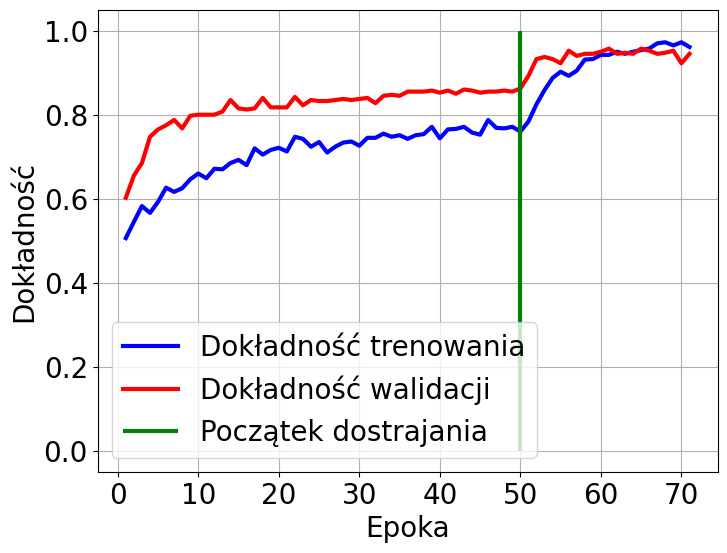

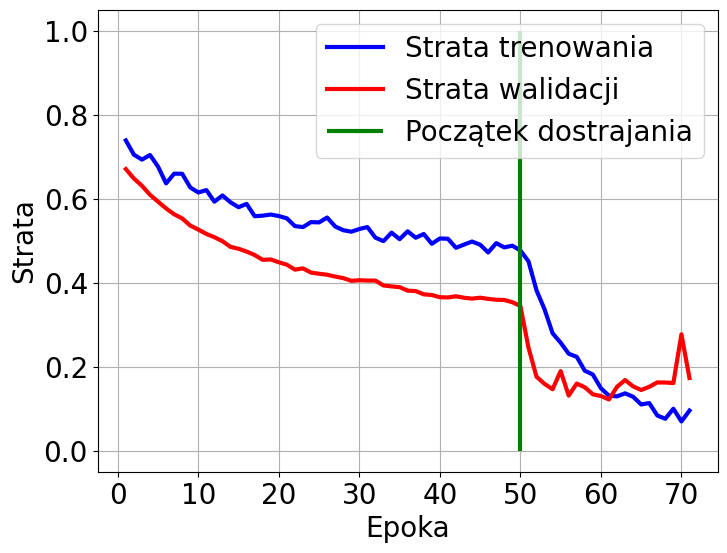

In [47]:
# Wyświetlenie wykresów trenowania i walidacji
trainingPlots(tuningHistory)

In [54]:
# Funkcja do budowy macierzy pomyłek
def plotCM(cm, labels):
    plt.figure(figsize = (4, 4))
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, horizontalalignment = "center", fontsize = 18)
    plt.yticks(tick_marks, labels, verticalalignment = "center", fontsize = 18)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
            horizontalalignment = "center",
            verticalalignment = "center",
            color = "white" if cm[i, j] > thresh else "black",
            fontsize = 20)
    plt.ylabel('Klasa rzeczywista', fontsize = 18)
    plt.xlabel('Klasa przewidywana', fontsize = 18)
    plt.tight_layout()
    plt.show()

In [49]:
# Definicja generatora danych testowych
def testGenerator():
    test_datagen = ImageDataGenerator(rescale = 1. / 255)
    test_generator = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size = IMAGE_SIZE,
            batch_size = TEST_BATCH_SIZE,
            class_mode = CLASS_MODE,
            shuffle = False)
    return test_generator

In [50]:
# Uruchomienie testowania modelu
model = keras.models.load_model('./' + MODEL_NAME)
test_generator = testGenerator()
labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
steps=test_generator.samples//test_generator.batch_size
test_generator.reset()
Y_pred = model.predict(test_generator, steps=steps, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

Found 400 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step


In [51]:
# Wyświetlenie metryk jakości klasyfikacji
LOSS, ACC = model.evaluate(test_generator, steps = steps, verbose = 1)
print("\nDokładność: %f\nStrata: %f\n" % (ACC, LOSS))

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - acc: 0.9342 - loss: 0.1800

Dokładność: 0.915000
Strata: 0.249754



In [52]:
# Wyświetlenie raportu klasyfikacji
print(classification_report(test_generator.classes, y_pred, target_names = list(labels.values())))

              precision    recall  f1-score   support

         men       0.90      0.94      0.92       200
       women       0.93      0.90      0.91       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.91       400
weighted avg       0.92      0.92      0.91       400



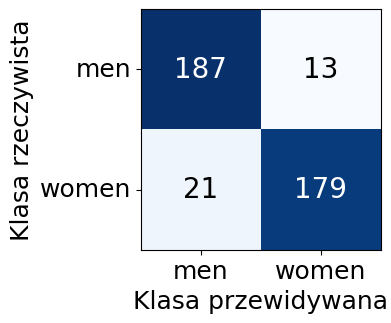

In [55]:
# Wyświetlenie macierzy pomyłek
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)
plotCM(cnf_matrix, list(labels.values()))

In [57]:
# Funkcja implementująca prognozę klasy nowych obrazów
def classPred(fileList):
  for filePath in fileList:
    org_img = load_img(filePath)
    raw_img = load_img(filePath, target_size = (150, 150))
    img = img_to_array(raw_img)
    img = np.expand_dims(img, axis = 0)
    img /= 255.
    prob = model.predict(img)
    predicted_class = np.argmax(prob)
    labels_list = list(labels.values())
    plt.imshow(org_img)
    plt.title('Prognoza: ' + labels_list[predicted_class])
    plt.axis('off')
    plt.show()

In [58]:
# Uruchomienie predykcji nowych obrazów
fileList = glob.glob('./men-women/predict/*')
classPred(fileList)

Output hidden; open in https://colab.research.google.com to view.